In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

In [2]:
# Define the city category
city_category = "small_medium"  # Change this to "Medium", "Large", or "Megacity"

# Load data
cities_df = pd.read_csv(f'../variables_clusters_{city_category}.csv')
UC_all_var = pd.read_csv('../urban_centres/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.csv', encoding='latin-1')


# Merge datasets on urban center ID
merged_df = cities_df.merge(UC_all_var[['ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']], on='ID_HDC_G0', how='left')

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.GCPNT_LON, merged_df.GCPNT_LAT))

# Convert population to millions
cities_df['pop_2015'] = cities_df['pop_2015'] / 1e6  

# Convert road lengths and distance to sea from meters to kilometers and then to millions of km
cities_df['road_motorway'] = cities_df['road_motorway'] / 1e3
cities_df['road_asphalt'] = cities_df['road_asphalt'] / 1e3
cities_df['road_others'] = cities_df['road_others'] / 1e3
cities_df['distance_sea'] = cities_df['distance_sea'] / 1e3

C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_29816\2857172533.py:6: DtypeWarning: Columns (9,10,13,14,15,16,17,18,19,26,27,28,29,30,31,32,33,34,35,36,45,46,47,53,54,55,56,57,58,59,63,67,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,123,124,125,126,127,128,129,130,153,154,155,156,157,159) have mixed types. Specify dtype option on import or set low_memory=False.
  UC_all_var = pd.read_csv('../urban_centres/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.csv', encoding='latin-1')


C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_29816\2959873950.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Cannot find header.dxf (GDAL_DATA is not defined)


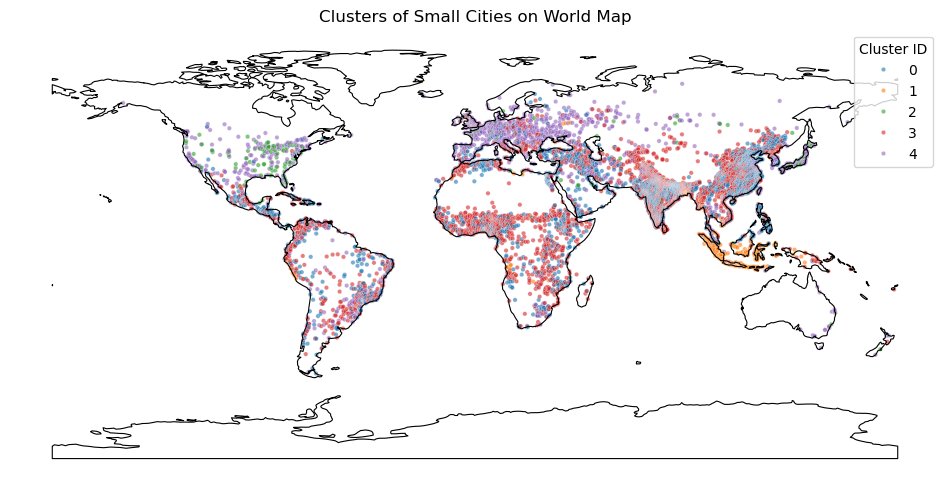

In [ ]:
# load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
landmass = world.dissolve()  # Merge all country geometries into one

#cluster colors
unique_clusters = sorted(gdf['y_pred_dec'].unique())  # Ensure consistent order
palette = sns.color_palette('tab10', n_colors=len(unique_clusters))
color_dict = {cluster: color for cluster, color in zip(unique_clusters, palette)}

def plot_world_map(ax):
    landmass.boundary.plot(ax=ax, color='black', linewidth=0.8)  # Only outer land borders
    landmass.plot(ax=ax, color='white', edgecolor='none')  # Fill land white, remove country borders
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)  # Hide the axis frame
    ax.set_xlabel("")
    ax.set_ylabel("")

#plot all clusters together
fig, ax = plt.subplots(figsize=(12, 6))
plot_world_map(ax)

sns.scatterplot(data=gdf, x='GCPNT_LON', y='GCPNT_LAT', hue='y_pred_dec', palette=color_dict, s=10, alpha=0.6, ax=ax)

ax.set_title("Clusters of Small Cities on World Map")
plt.legend(title="Cluster ID")
plt.show()

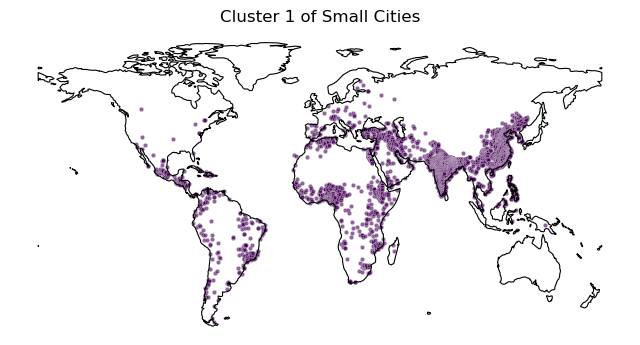

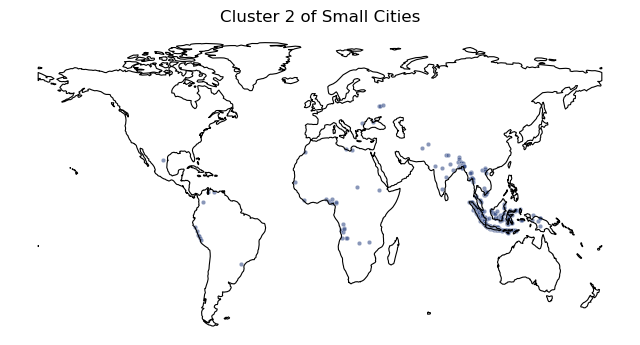

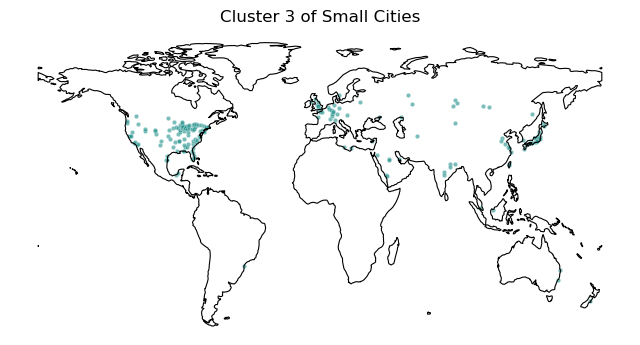

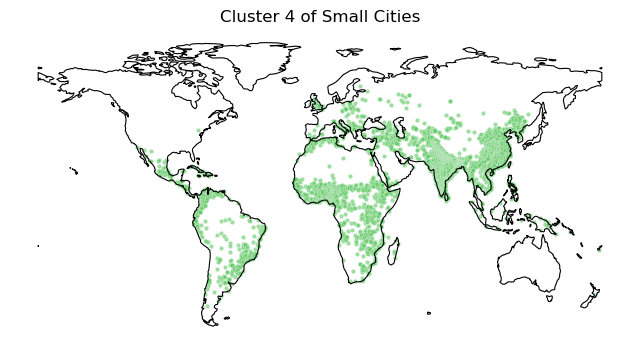

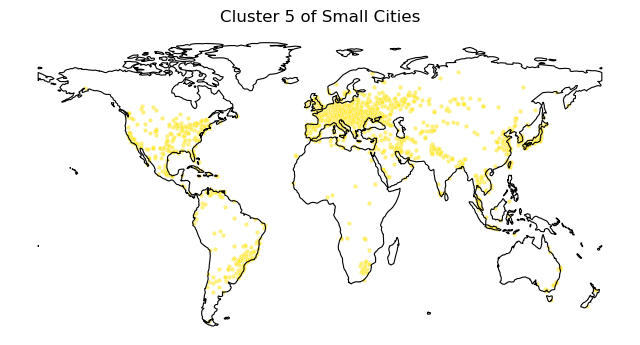

In [ ]:
# pot one map per cluster

# viridis colors 
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))  
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}  # Map clusters to colors

for cluster in unique_clusters:
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_world_map(ax)

    cluster_gdf = gdf[gdf['y_pred_dec'] == cluster]  # Select only cities in this cluster
    sns.scatterplot(data=cluster_gdf, x='GCPNT_LON', y='GCPNT_LAT', 
                    color=color_dict[cluster], s=10, alpha=0.6, ax=ax
                    )

    ax.set_title(f"Cluster {cluster+1} of Small Cities")

    # Crop out Antarctica
    ax.set_ylim(-60, 90)  # Limit latitude from -60° to 90° excludes Antarctica
    ax.set_aspect(1.3)
    plt.savefig(f'./small_medium/scatter_{city_category}_cluster_{cluster}.png', dpi=600, bbox_inches='tight')

    plt.show()


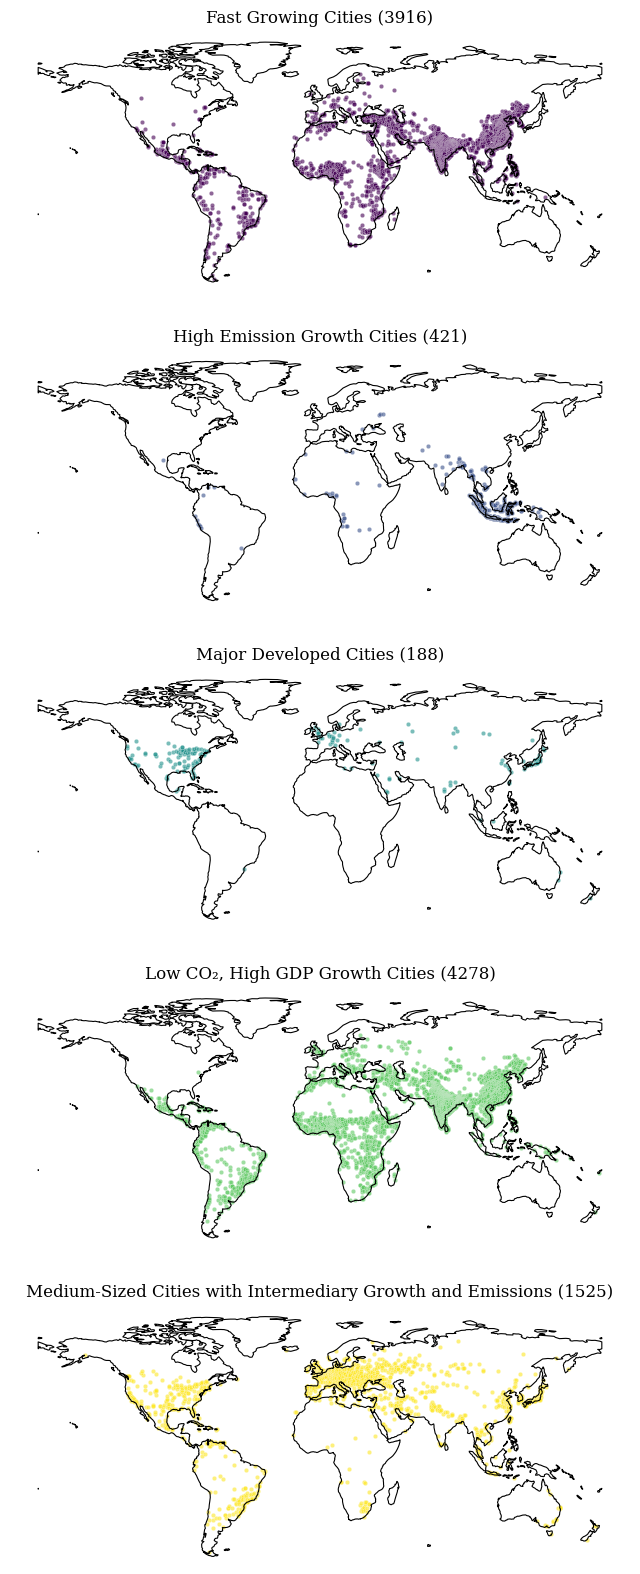

In [ ]:
#  titles for clusters
cluster_titles = {
    0: "Fast Growing Cities (3916)",
    1: "High Emission Growth Cities (421)",
    2: "Major Developed Cities (188)",
    3: "Low CO₂, High GDP Growth Cities (4278)",
    4: "Medium-Sized Cities with Intermediary Growth and Emissions (1525)"
}


fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(8, 4 * len(unique_clusters)), sharex=True, sharey=True)

#viridis colors
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))  
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

for ax, cluster in zip(axes, unique_clusters):
    plot_world_map(ax)  # Draw the basemap

    cluster_gdf = gdf[gdf['y_pred_dec'] == cluster]  # Select only cities in this cluster
    sns.scatterplot(data=cluster_gdf, x='GCPNT_LON', y='GCPNT_LAT', 
                    color=color_dict[cluster], s=10, alpha=0.6, ax=ax
                   )

    ax.set_title(cluster_titles.get(cluster, f"Cluster {cluster+1}"), fontsize=12, fontfamily='DejaVu Serif')

    # Crop out Antarctica
    ax.set_ylim(-60, 90)  # Limit latitude from -60° to 90° excludes Antarctica
    ax.set_aspect(1.1)

# Reduce space between subplots
#plt.subplots_adjust(hspace=-0.8)  # Negative hspace reduces the gap

plt.savefig(f'./small_medium/scatter_{city_category}_stacked_clusters.png', dpi=600, bbox_inches='tight')
plt.show()


In [6]:
# Generate KDE heatmaps for each cluster
#for cluster in unique_clusters:
    #plot_kde_heatmap(cluster)

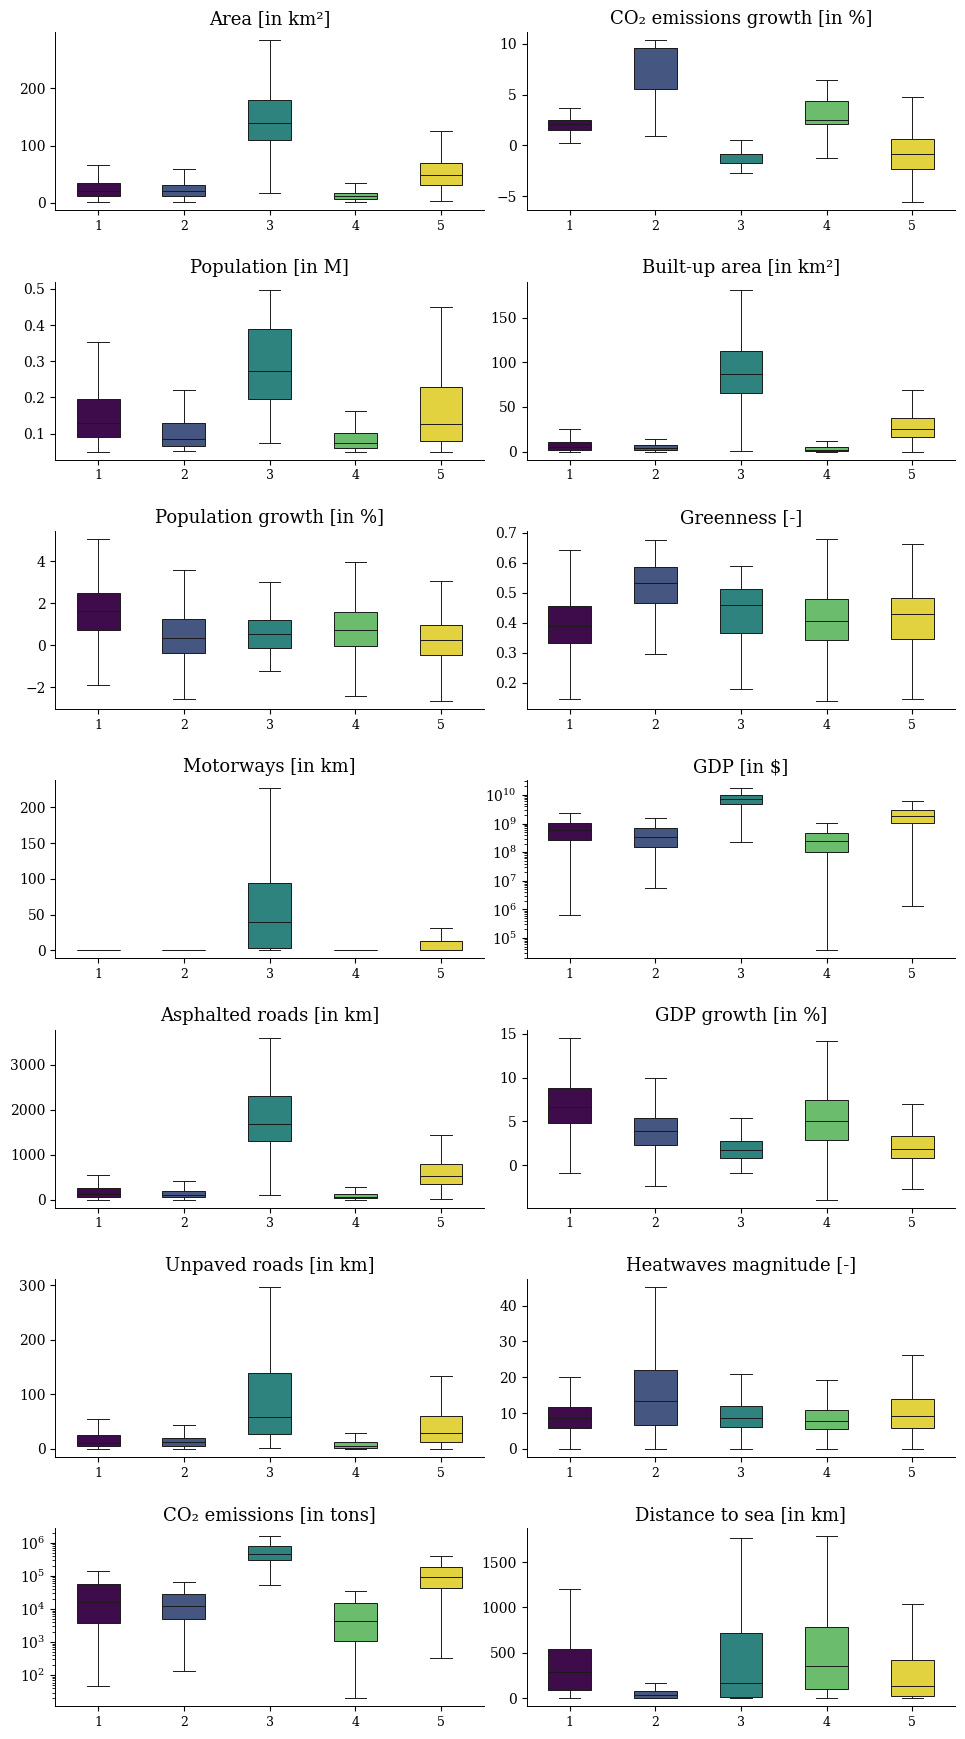

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec


#titles
variables_to_plot = [ 
    'AREA', 'pop_2015', 'pop_growth', 
    'road_motorway', 'road_asphalt', 'road_others', 
    'CO2_2022', 'CO2_recent_growth',
    'built_2015', 
    'green_2014', 'GDP_2015', 'GDP_growth',
    'heatwave', 'distance_sea'
]

title_dict = {
    'AREA': 'Area [in km²]',
    'pop_2015': 'Population [in M]',
    'pop_growth': 'Population growth [in %]',
    'road_motorway': 'Motorways [in km]',
    'road_asphalt': 'Asphalted roads [in km]',
    'road_others': 'Unpaved roads [in km]',
    'CO2_2022': 'CO₂ emissions [in tons]',
    'CO2_recent_growth': 'CO₂ emissions growth [in %]',
    'built_2015': 'Built-up area [in km²]',
    'green_2014': 'Greenness [-]',
    'GDP_2015': 'GDP [in $]',
    'GDP_growth': 'GDP growth [in %]',
    'heatwave': 'Heatwaves magnitude [-]',
    'distance_sea': 'Distance to sea [in km]',
}

unique_clusters = sorted(gdf['y_pred_dec'].unique())  

#font style and size
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10  



#viridis colors 
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))  
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# gridspec
fig = plt.figure(figsize=(10, 18)) 
gs = gridspec.GridSpec(7, 2)  



for i, var in enumerate(variables_to_plot):
    row = i % 7       # 0-6 (7 rows)
    col = i // 7      # 0 for first column, 1 for second column
    ax = fig.add_subplot(gs[row, col])
    ax.grid(False)  



    sns.boxplot(
        data=cities_df, x='y_pred_dec', y=var,
        hue='y_pred_dec', 
        palette=[color_dict[c] for c in unique_clusters],
        width=0.5,  # reduce box width to leave less space between clusters
        linewidth=0.7,  # thinner box borders
        showfliers=False, ax=ax,
        legend=False, dodge=False
    )

    # title
    ax.set_title(title_dict.get(var, var), fontsize=13, fontfamily='DejaVu Serif')

    ax.set_ylabel('')
    ax.set_xlabel('')

    # log scale for CO2 emissions and gdp
    if var == 'CO2_2022' or var == 'GDP_2015':
        ax.set_yscale('log')
        

    
    ax.set_xticks(range(len(unique_clusters)))
    ax.set_xticklabels([str(i+1) for i in unique_clusters], fontsize=9)
    


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.7)
    ax.spines['bottom'].set_linewidth(0.7)


fig.subplots_adjust(left=0.08, right=0.98, top=0.98, bottom=0.05, wspace=0.1, hspace=0.4)

# Save
plt.savefig(f'./small_medium/boxplots_{city_category}.png', dpi=600, bbox_inches='tight')

plt.show()


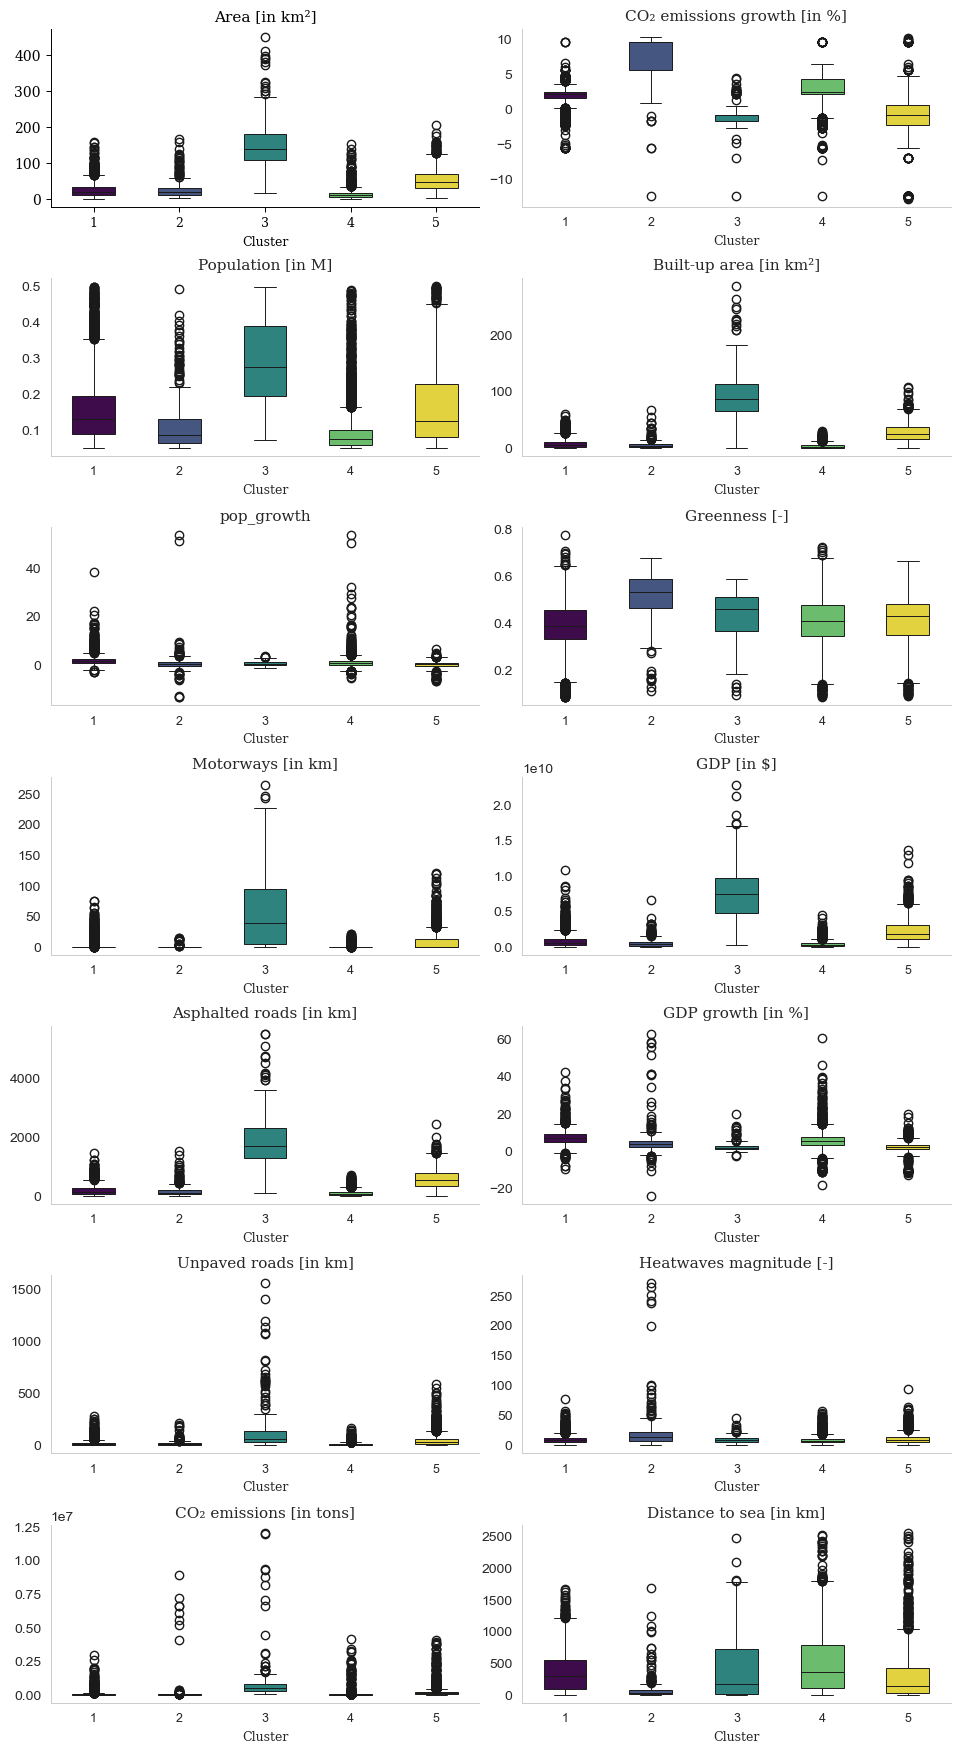

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec


plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.size'] = 10  


variables_to_plot = [ 
    'AREA', 'pop_2015', 'pop_growth', 
    'road_motorway', 'road_asphalt', 'road_others', 
    'CO2_2022', 'CO2_recent_growth',
    'built_2015', 
    'green_2014', 'GDP_2015', 'GDP_growth',
    'heatwave', 'distance_sea'
]

title_dict = {
    'AREA': 'Area [in km²]',
    'pop_2015': 'Population [in M]',
    'road_motorway': 'Motorways [in km]',
    'road_asphalt': 'Asphalted roads [in km]',
    'road_others': 'Unpaved roads [in km]',
    'CO2_2022': 'CO₂ emissions [in tons]',
    'CO2_recent_growth': 'CO₂ emissions growth [in %]',
    'built_2015': 'Built-up area [in km²]',
    'green_2014': 'Greenness [-]',
    'GDP_2015': 'GDP [in $]',
    'GDP_growth': 'GDP growth [in %]',
    'heatwave': 'Heatwaves magnitude [-]',
    'distance_sea': 'Distance to sea [in km]',
}

unique_clusters = sorted(gdf['y_pred_dec'].unique())  

#viridis colors 
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))  
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}


fig = plt.figure(figsize=(10, 18))  
gs = gridspec.GridSpec(7, 2)  

for i, var in enumerate(variables_to_plot):
    row = i % 7       
    col = i // 7      
    
    ax = fig.add_subplot(gs[row, col])
    ax.grid(False)  
    sns.set_style("whitegrid")

    sns.boxplot(
        data=cities_df, x='y_pred_dec', y=var,
        hue='y_pred_dec', 
        palette=[color_dict[c] for c in unique_clusters],
        width=0.5, 
        linewidth=0.7,  
        showfliers=True, ax=ax,
        legend=False, dodge=False
    )


    ax.set_title(title_dict.get(var, var), fontsize=11, fontfamily='serif')

    ax.set_ylabel('')


    #if var == 'CO2_2022' or var == 'GDP_2015':
        #ax.set_yscale('log')
    

    ax.set_xlabel('Cluster', fontsize=9, fontfamily='serif')
    ax.set_xticks(range(len(unique_clusters)))
    ax.set_xticklabels([str(i+1) for i in unique_clusters], fontsize=9)



    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.7)
    ax.spines['bottom'].set_linewidth(0.7)
    ax.yaxis.set_tick_params(width=0.7)
    ax.xaxis.set_tick_params(width=0.7)


fig.subplots_adjust(left=0.08, right=0.98, top=0.98, bottom=0.05, wspace=0.1, hspace=0.4)


plt.savefig(f'./small_medium/boxplots_{city_category}.png', dpi=600, bbox_inches='tight')

plt.show()


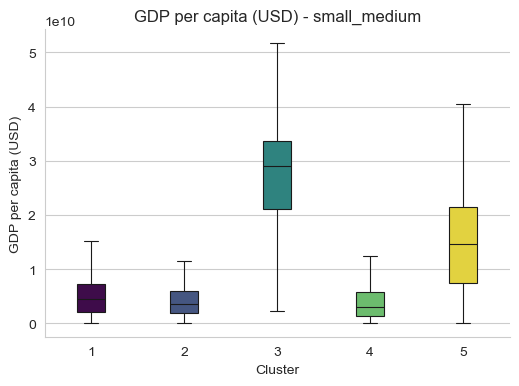

C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_29816\2912980695.py:70: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(f'./small_medium/boxplot_{var}_{city_category}.png', dpi=600, bbox_inches='tight')
d:\python\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


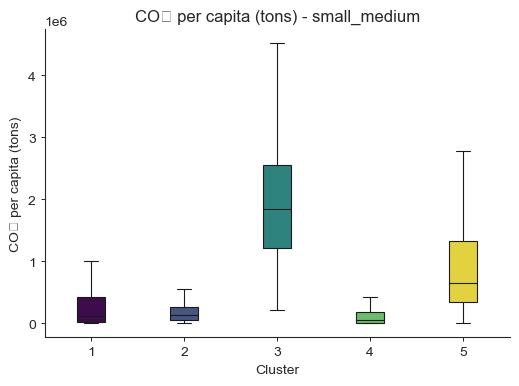

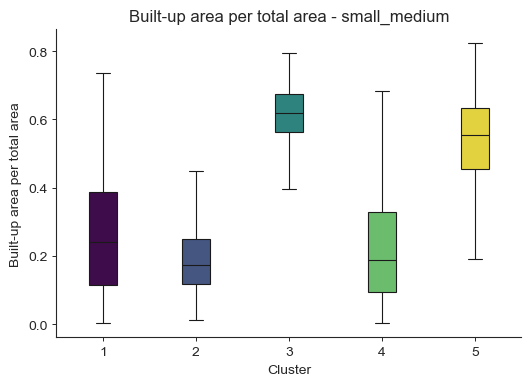

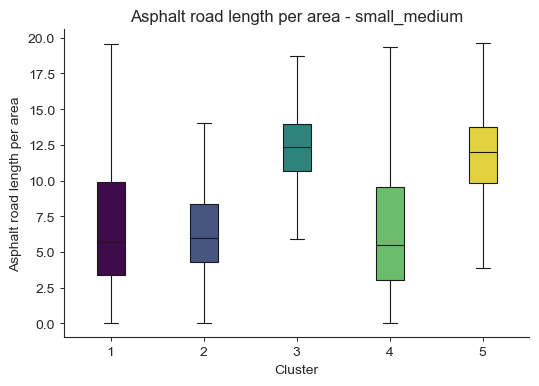

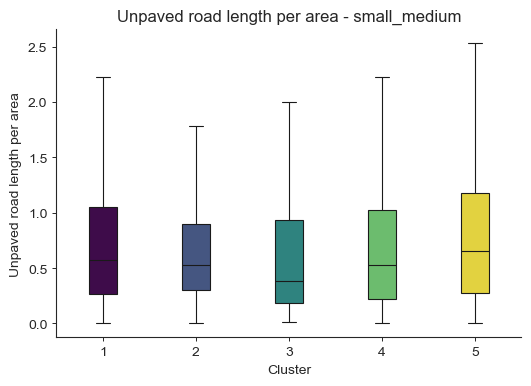

In [ ]:





cities_df_per_capita = pd.DataFrame()


cities_df_per_capita['y_pred_dec'] = cities_df['y_pred_dec']


cities_df_per_capita['GDP_per_capita'] = cities_df['GDP_2015'] / cities_df['pop_2015']
cities_df_per_capita['CO2_per_capita'] = cities_df['CO2_2022'] / cities_df['pop_2015']
cities_df_per_capita['built_per_area'] = cities_df['built_2015'] / cities_df['AREA']
cities_df_per_capita['road_asphalt_per_area'] = cities_df['road_asphalt'] / cities_df['AREA']
cities_df_per_capita['road_other_per_area'] = cities_df['road_others'] / cities_df['AREA']


new_variables_to_plot = ['GDP_per_capita', 'CO2_per_capita', 'built_per_area', 'road_asphalt_per_area', 'road_other_per_area']
new_variable_labels = {
    'GDP_per_capita': 'GDP per capita (USD)',
    'CO2_per_capita': 'CO₂ per capita (tons)',
    'built_per_area': 'Built-up area per total area',
    'road_asphalt_per_area': 'Asphalt road length per area',
    'road_other_per_area': 'Unpaved road length per area'
}

#viridis colors
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))  
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}  # Map clusters to colors

for var in new_variables_to_plot:
    fig, ax = plt.subplots(figsize=(6, 4))  


    plt.rcParams['font.family'] = 'serif'  
    plt.rcParams['font.size'] = 10  

    sns.set_style("whitegrid")
    sns.set_style("ticks")

    sns.boxplot(
        data=cities_df_per_capita, x='y_pred_dec', y=var,
        hue='y_pred_dec',  
        palette=[color_dict[c] for c in unique_clusters], 
        width=0.3, linewidth=0.8, showfliers=False, ax=ax,
        legend=False  
    )

    ax.set_title(f'{new_variable_labels[var]} - {city_category}', fontsize=12)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(new_variable_labels[var])

    ax.set_xlim(-0.5, len(unique_clusters) - 0.5) 


    ax.set_xticks(range(len(unique_clusters)))  
    ax.set_xticklabels([str(i+1) for i in unique_clusters])  

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.yaxis.set_tick_params(width=0.8)
    ax.xaxis.set_tick_params(width=0.8)

    
    plt.tick_params(axis='both', which='both', length=3, width=0.7)
    ax.yaxis.set_tick_params(length=3, width=0.7)
    ax.xaxis.set_tick_params(length=3, width=0.7)

    

    plt.savefig(f'./small_medium/boxplot_{var}_{city_category}.png', dpi=600, bbox_inches='tight')

    plt.show()


In [10]:
unique_clusters


[0, 1, 2, 3, 4]